### ***Deep Learning for Channel Coding via Neural Mutual Information Estimation***




This code implements an **Autoencoder-based communication system** with mutual information estimation (MINE).

- It simulates a communication channel where messages are encoded using a neural network-based encoder, transmitted through a noisy channel (AWGN or Rayleigh fading), and decoded by a neural network-based decoder.

- The system utilizes a Mutual Information Neural Estimator (MINE) to optimize the encoder and estimate mutual information between the transmitted and received signals. Performance evaluation includes calculating Batch Bit Error Rate (BER) and comparing against theoretical limits (16-QAM simulation).

- This setup allows for studying and optimizing the communication system under different SNR conditions.

In [7]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from scipy import special
from tensorflow import keras
import matplotlib.pyplot as plt
assert sys.version_info >= (3, 5)


# ------------------------------------------- Configure matplotlib --------------------------------------------
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ------------------------------------ Set random seeds for reproducibility ------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

### **AutoEncoder class for constructing a communication system with an autoencoder**

- This class initializes an autoencoder system with an encoder, channel model, and decoder. It includes methods for transforming EbN0 to noise power, sampling from a Rayleigh fading channel, generating random samples for testing, calculating Batch Bit Error Rate (BBER), and testing/visualizing the encoding process.

In [8]:
class AutoEncoder:
    def __init__(self, M=16, n=1, training_snr=7, rayleigh=False):
        self.M = M
        self.k = int(np.log2(M))
        self.n = n
        self.training_snr = training_snr
        self.rayleigh = rayleigh
        self.noise_std = self.EbNo_to_noise(training_snr)

        # Define custom layers
        self.norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2 * tf.reduce_mean(tf.square(x)))))
        self.shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2, n]))
        self.shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1, 2 * n]))
        self.channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=self.noise_std))

        # Define the encoder model
        self.encoder = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal', input_length=1),
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2 * n, activation=None),
            self.shape_layer,
            self.norm_layer
        ])

        if rayleigh:                                                                                                        # Define the channel model
            self.channel = keras.models.Sequential([keras.layers.Lambda(lambda x: self.sample_Rayleigh_channel(x, self.noise_std))])
        else:
            self.channel = keras.models.Sequential([self.channel_layer])

        self.decoder = keras.models.Sequential([                                                                            # Define the decoder model
            keras.layers.InputLayer(input_shape=[2, n]),
            self.shape_layer2,
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(M, activation="softmax")
        ])

        self.autoencoder = keras.models.Sequential([self.encoder, self.channel, self.decoder])                              # Combine encoder, channel, and decoder into an autoencoder model

    def EbNo_to_noise(self, ebnodb):
        '''Transform EbNo[dB]/snr to noise power'''
        ebno = 10**(ebnodb/10)
        noise_std = 1/np.sqrt(2*(self.k/self.n)*ebno)
        return noise_std

    def sample_Rayleigh_channel(self, x, noise_std):
        '''Sample from a Rayleigh fading channel'''
        h_sample = (1/np.sqrt(2)) * tf.sqrt(tf.random.normal(tf.shape(x))**2 + tf.random.normal(tf.shape(x))**2)
        z_sample = tf.random.normal(tf.shape(x), stddev=noise_std)
        y_sample = x + tf.divide(z_sample, h_sample)
        return tf.cast(y_sample, tf.float32)

    def random_sample(self, batch_size=32):
        '''Generate random samples for testing'''
        msg = np.random.randint(self.M, size=(batch_size, 1))
        return msg

    def B_Ber_m(self, input_msg, msg):
        '''Calculate the Batch Bit Error Rate'''
        batch_size = input_msg.shape[0]
        pred_error = tf.not_equal(tf.reshape(input_msg, shape=(-1, batch_size)), tf.argmax(msg, 1))
        bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
        return bber

    def test_encoding(self):
        '''Test the encoding process and visualize'''
        inp = np.arange(0, self.M)
        coding = self.encoder.predict(inp)
        fig = plt.figure(figsize=(4,4))
        plt.plot(coding[:,0], coding[:, 1], "b.")
        plt.xlabel("$x_1$", fontsize=18)
        plt.ylabel("$x_2$", fontsize=18, rotation=0)
        plt.grid(True)
        plt.gca().set_ylim(-2, 2)
        plt.gca().set_xlim(-2, 2)
        plt.show()


### **Neural Network Function model for computing scores based on concatenated inputs.**

This class initializes a neural network with layers of specified dimensions and activation functions. The `call` method computes scores based on concatenated inputs `x` and `y`, where `x` and `y` are tiled to match the batch size. The concatenated pairs are passed through the sequential model `_f` to produce scores, which are reshaped and transposed for proper output shape.

- Parameters:

   - hidden_dim (int): Dimension of the hidden layers.
   - layers (int): Number of dense layers in the model.
   - activation (str or callable): Activation function for dense layers.
   - extra_kwargs: Additional keyword arguments for customization.

- Methods:

    - __init__: Initialize the neural network function with specifie parameters.
    - call(x, y): Compute scores based on concatenated inputs `x` and `y`.

In [9]:
class NNFunction(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        '''Initialize the neural network function.'''
        super(NNFunction, self).__init__()
        self._f = tf.keras.Sequential(
            [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
            [tf.keras.layers.Dense(1)]
        )

    def call(self, x, y):
        '''Compute the scores based on the concatenated inputs.'''
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :], (batch_size, 1, 1))                                                   # Tile x to match the batch size
        y_tiled = tf.tile(y[:, None], (1, batch_size, 1))                                                   # Tile y to match the batch size
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])         # Concatenate x and y pairs
        scores = self._f(xy_pairs)                                                                          # Compute scores using the sequential model
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))                                   # Reshape scores and transpose for proper output shape

### **Trainer class for training an autoencoder and neural network function**

This class encapsulates methods to train different components of an autoencoder system:

  - Mutual Information Neural Estimator (MINE)
  - Autoencoder decoder
  - Autoencoder encoder and MINE simultaneously

It includes methods to compute and optimize losses, plot training progress, and evaluate performance metrics such as Bit Error Rate (BER) under varying Signal-to-Noise Ratio (SNR).

- Attributes:
  - autoencoder (AutoEncoder): Instance of AutoEncoder model.
  - nn_function (NNFunction): Instance of NNFunction model.
  - loss_fn (tf.keras.losses): Loss function used for training.
  - mean_loss (tf.keras.metrics.Mean): Mean loss metric for tracking loss during training.

- Methods:
  - MINE(scores): Compute Mutual Information Neural Estimator (MINE) loss.
  - plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding): Print and optionally plot loss during training.
  - plot_batch_loss(epoch, mean_loss, X_batch, y_pred): Print interim loss during training.
  - train_mi(n_epochs, n_steps, batch_size, learning_rate): Train Mutual Information Neural Estimator (MINE).
  - train_decoder(n_epochs, n_steps, batch_size, learning_rate, plot_encoding): Train autoencoder decoder.
  - train_encoder(n_epochs, n_steps, batch_size, learning_rate): Train autoencoder encoder and Mutual Information Neural Estimator (MINE).
  - test_ae(): Evaluate Bit Error Rate (BER) for varying SNRs and return results.


In [10]:
class Trainer:
    def __init__(self, autoencoder, nn_function):
        self.autoencoder = autoencoder
        self.nn_function = nn_function
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy()
        self.mean_loss = keras.metrics.Mean()

    def MINE(self, scores):
        '''Compute MINE loss'''
        def marg(x):
            batch_size = x.shape[0]
            marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
            return marg_ * ((batch_size * batch_size) / (batch_size * (batch_size - 1.)))
        joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
        marg_term = marg(scores)
        return joint_term - tf.math.log(marg_term)

    def plot_loss(self, step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
        '''Print and optionally plot loss during training'''
        template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        if step % 10 == 0:
            print(template.format(step, epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))
            if plot_encoding:
                self.autoencoder.test_encoding()

    def plot_batch_loss(self, epoch, mean_loss, X_batch, y_pred):
        '''Print interim loss during training'''
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.5f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), self.autoencoder.B_Ber_m(X_batch, y_pred)))

# ----------------------------------------------------------------- TRAINING METHODS -------------------------------------------------------------------------------

    def train_mi(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005):
        '''Train mutual information estimator.'''
        optimizer_mi = keras.optimizers.Nadam(lr=learning_rate)                                                           # Initialize Nadam optimizer for MI estimator
        for epoch in range(1, n_epochs + 1):
            print("Training in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                      # Generate random input batch
                with tf.GradientTape() as tape:
                    x_enc = self.autoencoder.encoder(X_batch, training=True)                                              # Encode input batch
                    y_recv = self.autoencoder.channel(x_enc)                                                              # Simulate channel
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                     # Reshape encoded input
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])                                    # Reshape received signal
                    score = self.nn_function(x, y)                                                                        # Compute score using neural network function
                    loss = -self.MINE(score)                                                                              # Calculate loss using MINE estimator
                    gradients = tape.gradient(loss, self.nn_function.trainable_variables)                                 # Compute gradients
                    optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))                    # Apply gradients
                mi_avg = -self.mean_loss(loss)                                                                            # Calculate average mutual information
            print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))                                                            # Print mutual information for the epoch
            self.mean_loss.reset_states()                                                                                 # Reset mean_loss metric for next epoch


    def train_decoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.005, plot_encoding=True):
        '''Train autoencoder decoder.'''
        optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)                                                           # Initialize Nadam optimizer for autoencoder decoder
        for epoch in range(1, n_epochs + 1):
            print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                      # Generate random input batch
                with tf.GradientTape() as tape:
                    y_pred = self.autoencoder.autoencoder(X_batch, training=True)                                         # Predict using autoencoder
                    loss = tf.reduce_mean(self.loss_fn(X_batch, y_pred))                                                  # Compute loss using sparse categorical cross-entropy
                    gradients = tape.gradient(loss, self.autoencoder.decoder.trainable_variables)                         # Compute gradients
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.decoder.trainable_variables))            # Apply gradients
                self.mean_loss(loss)                                                                                      # Update mean_loss metric with current loss
                self.plot_loss(step, epoch, self.mean_loss, X_batch, y_pred, plot_encoding)                               # Plot loss and encoding (if enabled)
            self.plot_batch_loss(epoch, self.mean_loss, X_batch, y_pred)                                                  # Plot batch loss for the epoch
            self.mean_loss.reset_states()                                                                                 # Reset mean_loss metric for next epoch


    def train_encoder(self, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05):
        '''Train autoencoder encoder and mutual information estimator.'''
        optimizer_mi = keras.optimizers.Nadam(lr=0.005)                                                                   # Initialize optimizer for mutual information estimator
        optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)                                                           # Initialize optimizer for autoencoder encoder
        for epoch in range(1, n_epochs + 1):
            print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
            for step in range(1, n_steps + 1):
                X_batch = self.autoencoder.random_sample(batch_size)                                                      # Generate random input batch
                with tf.GradientTape() as tape:
                    x_enc = self.autoencoder.encoder(X_batch, training=True)                                              # Encode input batch
                    y_recv = tf.grad_pass_through(self.autoencoder.channel)(x_enc)                                        # Simulate channel with gradient pass-through
                    x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                     # Reshape encoded input
                    y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])                                    # Reshape received signal
                    score = self.nn_function(x, y)                                                                        # Compute score using neural network function
                    loss = -self.MINE(score)                                                                              # Calculate loss using MINE estimator
                    gradients = tape.gradient(loss, self.autoencoder.encoder.trainable_variables)                         # Compute gradients
                    optimizer_ae.apply_gradients(zip(gradients, self.autoencoder.encoder.trainable_variables))            # Apply gradients
                mi_avg = -self.mean_loss(loss)                                                                            # Calculate average mutual information
            with tf.GradientTape() as tape:
                X_batch = self.autoencoder.random_sample(batch_size)                                                      # Generate random input batch
                x_enc = self.autoencoder.encoder(X_batch, training=True)                                                  # Encode input batch
                y_recv = self.autoencoder.channel(x_enc)                                                                  # Simulate channel
                x = tf.reshape(x_enc, shape=[batch_size, 2 * self.autoencoder.n])                                         # Reshape encoded input
                y = tf.reshape(y_recv, shape=[batch_size, 2 * self.autoencoder.n])                                        # Reshape received signal
                score = self.nn_function(x, y)                                                                            # Compute score using neural network function
                loss = -self.MINE(score)                                                                                  # Calculate loss using MINE estimator
                gradients = tape.gradient(loss, self.nn_function.trainable_variables)                                     # Compute gradients
                optimizer_mi.apply_gradients(zip(gradients, self.nn_function.trainable_variables))                        # Apply gradients
            print('Epoch: {}, Mi is {}'.format(epoch, mi_avg))                                                            # Print mutual information for the epoch

# ---------------------------------------------------------------------- TEST METHODS -------------------------------------------------------------------------------------

    def test_ae(self):
        '''Calculate Bit Error for varying SNRs.'''
        snr_range = np.linspace(0, 15, 31)                                                                                # Generate SNR values from 0 to 15 dB with 31 points
        bber_vec = [None] * len(snr_range)                                                                                # Initialize list to store Bit Error Rate (BER) results for each SNR
        for db in range(len(snr_range)):                                                                                  # Loop over each SNR value
            for it in range(1, 1000):                                                                                     # Perform 1000 iterations for averaging BER at each SNR
                noise_std = self.autoencoder.EbNo_to_noise(snr_range[db])                                                 # Calculate noise standard deviation from SNR
                X_batch = self.autoencoder.random_sample(500)                                                             # Generate random input batch for testing
                code_word = self.autoencoder.encoder(X_batch)                                                             # Encode input batch to get codewords
                if self.autoencoder.rayleigh:
                    rcvd_word = self.autoencoder.sample_Rayleigh_channel(code_word, noise_std)                            # Simulate Rayleigh fading channel
                else:
                    rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)             # Add AWGN
                dcoded_msg = self.autoencoder.decoder(rcvd_word)                                                          # Decode received word to get decoded messages
                bber = self.autoencoder.B_Ber_m(X_batch, dcoded_msg)                                                      # Calculate Batch Bit Error Rate (BER)
                bber_avg = self.mean_loss(bber)                                                                           # Calculate average BER across the batch
            bber_vec[db] = bber_avg                                                                                       # Store average BER for current SNR
            self.mean_loss.reset_states()                                                                                 # Reset mean_loss metric for next SNR calculation
            if (db % 6 == 0) & (db > 0):
                print(f'Progress: {db} of {30} parts')
        return (snr_range, bber_vec)


### **The provided code initializes an autoencoder and a neural network function for communication system simulation.**

- It sets up parameters such as the number of symbols (M = 16) and dimensions per symbol (n = 1), along with a training Signal-to-Noise Ratio (TRAINING_SNR = 7). The autoencoder is trained in several stages: first, it trains a mutual information estimator over 500 steps to assess information capacity. Then, the encoder is trained over 5 epochs and 400 steps to optimize signal encoding, using a learning rate of 0.005. Subsequently, the encoder's performance is evaluated through testing. Finally, the decoder undergoes 5 epochs and 400 steps of training at a batch size of 500, aiming to reconstruct signals accurately, with no encoding plots generated during this phase (plot_encoding=False).

Training in Epoch 1/1


Epoch: 1, Mi is 1.95937979221344
Training Bob in Epoch 1/5
Epoch: 1, Mi is 2.440868616104126
Training Bob in Epoch 2/5
Epoch: 2, Mi is 2.436171531677246
Training Bob in Epoch 3/5
Epoch: 3, Mi is 2.4491283893585205
Training Bob in Epoch 4/5
Epoch: 4, Mi is 2.4590680599212646
Training Bob in Epoch 5/5
Epoch: 5, Mi is 2.466041326522827
1/1 [==============================] - 0s 117ms/step


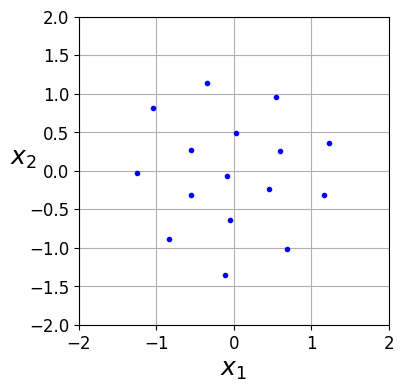

Training Bob in Epoch 1/5
Iteration: 10, Epoch: 1, Loss: -2.44000, Batch_BER: 0.92400
Iteration: 20, Epoch: 1, Loss: -2.41440, Batch_BER: 0.87400
Iteration: 30, Epoch: 1, Loss: -2.38925, Batch_BER: 0.84200
Iteration: 40, Epoch: 1, Loss: -2.36449, Batch_BER: 0.82200
Iteration: 50, Epoch: 1, Loss: -2.34019, Batch_BER: 0.80400
Iteration: 60, Epoch: 1, Loss: -2.31632, Batch_BER: 0.78600
Iteration: 70, Epoch: 1, Loss: -2.29286, Batch_BER: 0.75000
Iteration: 80, Epoch: 1, Loss: -2.26984, Batch_BER: 0.68000
Iteration: 90, Epoch: 1, Loss: -2.24718, Batch_BER: 0.69200
Iteration: 100, Epoch: 1, Loss: -2.22496, Batch_BER: 0.60800
Iteration: 110, Epoch: 1, Loss: -2.20311, Batch_BER: 0.62400
Iteration: 120, Epoch: 1, Loss: -2.18167, Batch_BER: 0.59800
Iteration: 130, Epoch: 1, Loss: -2.16066, Batch_BER: 0.60200
Iteration: 140, Epoch: 1, Loss: -2.13999, Batch_BER: 0.54000
Iteration: 150, Epoch: 1, Loss: -2.11974, Batch_BER: 0.59800
Iteration: 160, Epoch: 1, Loss: -2.09988, Batch_BER: 0.56400
Iterati

In [11]:
# Define parameters
M = 16
n = 1
TRAINING_SNR = 7
rayleigh = False

autoencoder = AutoEncoder(M=M, n=n, training_snr=TRAINING_SNR, rayleigh=rayleigh)                                         # Initialize AutoEncoder and NNFunction
critic_params = {
    'layers': 2,
    'hidden_dim': 256,
    'activation': 'relu',
}
nn_function = NNFunction(**critic_params)
trainer = Trainer(autoencoder, nn_function)                                                                               # Initialize Trainer
trainer.train_mi(n_epochs=1, n_steps=500, batch_size=64)                                                                  # Train mutual information estimator
trainer.train_encoder(n_epochs=5, n_steps=400, batch_size=64, learning_rate=0.005)                                        # Train encoder
autoencoder.test_encoding()                                                                                               # Test encoding
trainer.train_decoder(n_epochs=5, n_steps=400, batch_size=500, learning_rate=0.005, plot_encoding=False)                  # Train decoder
bber_data = trainer.test_ae()                                                                                             # Test AE

- This code computes and compares the Symbol Error Rate (SER) for 16-QAM modulation in both AWGN (Additive White Gaussian Noise) and Rayleigh fading channels. It plots the Batch Symbol Error Rate (BER) data from an autoencoder (AE with MINE) against theoretical approximations (16QAM Rayleigh Approx or 16QAM AWGN Approx) over a range of Eb/N0 values (ebnodbs). The plot helps assess the autoencoder's performance under different noise and channel conditions.

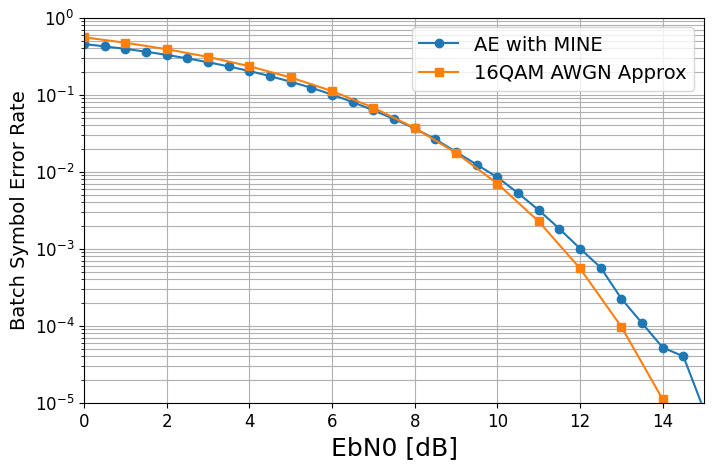

In [12]:
def SIXT_QAM_sim(ebno):
    '''Function to approximate 16 QAM error in AWGN channel'''
    return (3.0/2) * special.erfc(np.sqrt((4.0/10) * 10.**(ebno/10)))

def MQAM_rayleigh_approx(M, ebnodb):
    '''Function to approximate M-QAM error in Rayleigh fading channel'''
    ebno = 10.**(ebnodb/10)
    esno = 4 * ebno
    a = 3.25
    b = 3 / (M - 1)
    e = b * esno
    return (a / 2) * (1 - np.sqrt(0.5 * e / (1 + 0.5 * e))), a / (2 * b * esno)

ebnodbs = np.linspace(0, 15, 16)                                                                                          # Define range of Eb/N0 values
fig = plt.figure(figsize=(8, 5))                                                                                          # Create a figure for plotting
plt.semilogy(bber_data[0], bber_data[1], 'o-', label='AE with MINE')                                                      # Plot the Batch Bit Error Rate (BER) data from the autoencoder test

if rayleigh:                                                                                                              # Plot theoretical error rates based on the channel mode
    a, b = MQAM_rayleigh_approx(16, ebnodbs)                                                                              # For Rayleigh fading channel
    plt.plot(ebnodbs, a, 's-', label='16QAM Rayleigh Approx')
else:
    plt.plot(ebnodbs, SIXT_QAM_sim(ebnodbs), 's-', label='16QAM AWGN Approx')                                             # For AWGN channel

plt.gca().set_ylim(1e-5, 1)                                                                                               # Set the y-axis to a logarithmic scale and limits
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("EbN0 [dB]", fontsize=18)
plt.legend(prop={'size': 14}, loc='upper right')
plt.grid(True, which="both")
plt.show()
